In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#this class needs to be an autoencoder to generate 28x28 images
class Discriminator(nn.Module):

    def __init__(self, n_dim=8, input_height=32, input_width = 32, cond_size = 10 ):
        super(Discriminator, self).__init__()
        
        #4 fully connected layers with BN and ReLu activations to keep it simple
        
        
        #input layer, takes in 1x64x64 input, outputs 
        self.in_layer = nn.Sequential(
                        nn.Linear(input_height*input_width + cond_size,64*n_dim), 
                        #nn.BatchNorm1d(64*n_dim),
                        #nn.Dropout(.5),
                        nn.ReLU(True)
                        )
        
        #hidden layers
        self.mid_layer = nn.Sequential(
                         nn.Linear(64*n_dim,64*n_dim), 
                         #nn.BatchNorm1d(64*n_dim),
                         #nn.Dropout(.5),
                         nn.ReLU(True)
                         )
        
        #output layer 
        self.out_layer = nn.Sequential(
                         nn.Dropout(.5),
                         nn.Linear(64*n_dim,1),#10 output categories for MNIST 
                         nn.Sigmoid()
                         )
        
        self.main = nn.Sequential(self.in_layer, 
                    self.mid_layer, 
                    self.mid_layer, 
                    self.out_layer
                    )

    def forward(self, x):
        """
        4 fully connected layers with sigmoid output
        """
        return self.main(torch.flatten(x,start_dim = 1))


class Generator(nn.Module):

    def __init__(self, n_dim=16, noise_dim=100,output_height = 32, output_width = 32,cond_size = 10):
        super(Generator, self).__init__()
        
        #network with 4 fully connected layers with higher capacity than the discriminator
        self.in_layer = nn.Sequential(
                        nn.Linear(noise_dim+ cond_size, 64*n_dim),
                        nn.BatchNorm1d(64*n_dim), 
                        nn.ReLU(True)   
                        #nn.Sigmoid()
                        )
        #hidden layers
        self.mid_layer = nn.Sequential(
                        nn.Linear(64*n_dim, 64*n_dim),
                        nn.BatchNorm1d(64*n_dim), 
                        nn.ReLU(True)   
                        #nn.Sigmoid()      
                        )
        
        #output layer
        
        self.out_layer = nn.Sequential(
                         nn.Linear(64*n_dim, output_height*output_width),
                         nn.Sigmoid()#no normalization in output layer        
                         )
        
        
        self.main = nn.Sequential(
                    self.in_layer, 
                    self.mid_layer, 
                    self.mid_layer, 
                    self.out_layer
                    )
    def forward(self, x):
        """
        compute image from noise using fully connected layers
        """
        x = self.main(torch.flatten(x,start_dim =1))
        
        return x

def weights_init(m): 
    classname = m.__class__.__name__
    if classname.find('Linear') != -1: 
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1: 
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [ ]:
#import data for MNIST 
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(),transforms.Normalize(0,1)])
train_data = datasets.MNIST(
    root = 'data', 
    train = True, 
    transform =   transform,
    download = True
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform =  transform
)


loaders = {'train': torch.utils.data.DataLoader(train_data, batch_size = 500, shuffle = True,num_workers = 1, pin_memory = True), 
          'test' : torch.utils.data.DataLoader(test_data, batch_size = 500, shuffle = True, num_workers = 1, pin_memory = True)}


#define model 
torch.cuda.empty_cache()


In [ ]:
import time
def train_GAN(epochs, discriminator, generator, loaders,dOptim, gOptim, dLoss, gLoss, disc_scheduler, gen_scheduler,noise_dim=100,batch_size = 500): 
    torch.cuda.empty_cache()
    total_step = len(loaders['train']) 
    labels = np.zeros(batch_size*2) 
    labels[:batch_size] = 1
    labels = torch.from_numpy(labels.astype(np.float32))
    labels = labels.cuda()
    
    #here we define the fixed noise vector
    dim_fixed_noise = 5
    fixed_noise = torch.rand(dim_fixed_noise,noise_dim,1,1,device = device)
    fixed_noise = torch.flatten(fixed_noise,start_dim =1) 
    
    time_diff = [] 
    
    for epoch in range(epochs): 
        TS  = time.time() 
        #print(torch.cuda.memory_summary(device=device, abbreviated=False))
        for i , data in enumerate(loaders['train'],0): 
            #loads true inputs 
            true_inputs,to_encode = data
            true_inputs = true_inputs.cuda()
            to_encode = to_encode.cuda()
            encoded_labels = F.one_hot(to_encode)*10
            
            
            t1 = time.time() 
            #training Discriminator network on real data 
            discriminator.zero_grad()
            true_inputs = torch.flatten(true_inputs,start_dim = 1)
            real_input = torch.cat((true_inputs,encoded_labels),1)
            
            output =  discriminator(real_input).view(-1)
            errD_real = dLoss(output, labels[:batch_size]) 
            errD_real.backward(retain_graph = True) 
            D_x = output.mean().item() 
            
            #train D with fake batch 
            #generate false outputs
            noise = torch.rand(batch_size,noise_dim,device = device)
            noise_input = torch.cat((noise,encoded_labels),1)

            
            false_inputs = generator(noise_input)
            false_inputs = torch.flatten(false_inputs,start_dim = 1) 
            
            
            false_inputs = torch.cat((false_inputs,encoded_labels),1)
            
            
            output = discriminator(false_inputs).view(-1) 
            
            errD_fake = dLoss(output,labels[batch_size:]) 
            errD_fake.backward(retain_graph = True) 
            D_G_z1 = output.mean().item() 
            #total D error 
            errD = (errD_real + errD_fake)/2 
            
            #now update G 
            generator.zero_grad()
            output = discriminator(false_inputs).view(-1) 
            #output = discriminator(false_inputs).view(-1) 
            errG = gLoss(output,labels[:batch_size]) 
            errG.backward()
            D_G_z2 = output.mean().item() 
            #update G and D
            
            dOptim.step() 
            gOptim.step() 
            
            
            t2 = time.time()    
            time_diff.append((t2-t1)/total_step) 
            if (i+1) % (total_step/2) == 0: 
                print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.8f}, Generator Loss: {:.8f}, Pass Rates (real/fake): {:.8f} {:.8f}' 
                       .format(epoch + 1, epochs, i + 1, total_step, errD.item(),errG.item(), D_x,D_G_z2))
                resize_transform = transforms.Resize(64)
                
                full_mat = np.zeros([64*dim_fixed_noise,640])
              

                for j in range(10): 
                    fixed_labels = (torch.ones((1,dim_fixed_noise),device = device)*j).type(torch.int64)
                    fixed_encoded_labels = torch.squeeze(F.one_hot(fixed_labels,num_classes= 10))
                    fixed_noise_input = torch.cat((fixed_noise, fixed_encoded_labels),1)
                    test_output = generator(fixed_noise_input)
                    test_output = resize_transform(torch.reshape(test_output,(dim_fixed_noise, 32,32)))#resize output 
                    full_mat[:,j*64:(j+1)*64] = test_output.view(dim_fixed_noise*64,64).cpu().detach().numpy()
                    
                
                img = Image.fromarray(np.uint8(full_mat * 255) , 'L')
                print('test Image: \n')
                display(img)
        TE = time.time() 
        
        print('average step time: {:.8f}, total time for epoch: {:2.4f}'.format(sum(time_diff), (TE-TS)/total_step ))
        time_diff = []
        disc_scheduler.step() 
        gen_scheduler.step()
    return generator, discriminator 

Epoch [1/70], Step [60/120], Discriminator Loss: 0.22216827, Generator Loss: 0.15828112, Pass Rates (real/fake): 0.74616432 0.60840714
test Image: 



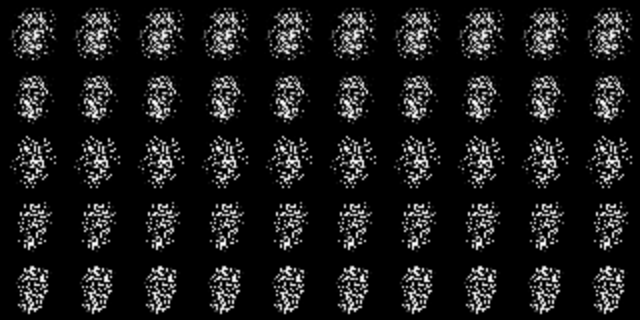

Epoch [1/70], Step [120/120], Discriminator Loss: 0.21723524, Generator Loss: 0.16403547, Pass Rates (real/fake): 0.74783063 0.59867448
test Image: 



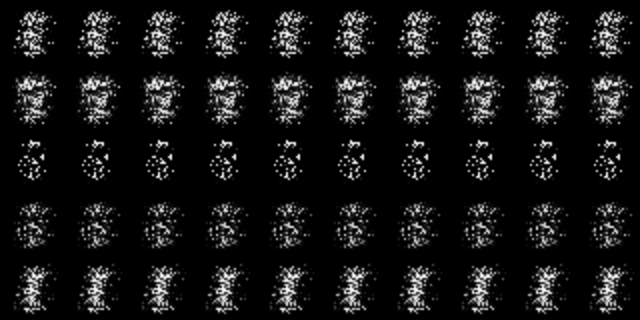

average step time: 0.02537589, total time for epoch: 0.0666
Epoch [2/70], Step [60/120], Discriminator Loss: 0.24999060, Generator Loss: 0.14272654, Pass Rates (real/fake): 0.69193459 0.62622565
test Image: 



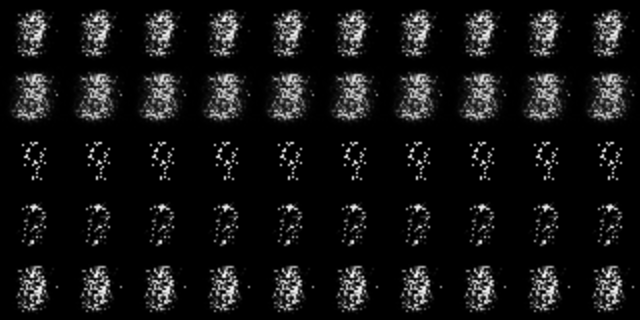

KeyboardInterrupt: 

In [ ]:
from PIL import Image
torch.cuda.empty_cache()
noise_dim = 100
g_net = Generator(n_dim =64, noise_dim=noise_dim) 
d_net = Discriminator(n_dim = 32) 
g_net.cuda() 
d_net.cuda() 
dis_loss = nn.MSELoss() 
gen_loss = nn.MSELoss() 
#dis_loss = nn.BCELoss() 
#gen_loss = nn.BCELoss() 
dis_optim = optim.Adam(d_net.parameters(), lr = .0001,betas=(0.5, 0.99))
#dis_optim = optim.RMSprop(d_net.parameters(), lr = .0005, centered = True)
gen_optim = optim.Adam(g_net.parameters(), lr = .001,betas=(0.5, 0.99))
#gen_optim = optim.RMSprop(g_net.parameters(),lr = .0001)
#dis_optim = optim.SGD(d_net.parameters(), lr = .1,momentum = .9, weight_decay = .0001)
#gen_optim = optim.SGD(g_net.parameters(), lr = .1,momentum = 0, weight_decay = .0001)
schedulerD =torch.optim.lr_scheduler.StepLR(dis_optim, step_size = 100, gamma=.1, verbose=False)
schedulerG =torch.optim.lr_scheduler.StepLR(gen_optim, step_size = 100, gamma=.1, verbose=False)

G, D = train_GAN(70,d_net,g_net, loaders, dis_optim, gen_optim, dis_loss, gen_loss,schedulerD, schedulerG,noise_dim=noise_dim)

In [ ]:
full_mat = np.zeros([640,640])
noise = torch.rand(10,noise_dim,1,1,device = device)
noise = torch.flatten(noise,start_dim =1) 
resize_transform = transforms.Resize(64)

for i in range(10): 
    fixed_labels = (torch.ones((1,10),device = device)*i).type(torch.int64)
    fixed_encoded_labels = torch.squeeze(F.one_hot(fixed_labels,num_classes= 10))
    fixed_noise_input = torch.cat((noise, fixed_encoded_labels),1)
    test_output = G(fixed_noise_input)
    test_output = resize_transform(torch.reshape(test_output,(10, 32,32)))#resize output 
    full_mat[:,i*64:(i+1)*64] = test_output.view(640,64).cpu().detach().numpy()



#full_mat = np.where(full_mat > 0, full_mat, 0)
img = Image.fromarray(np.uint8(full_mat * 255) , 'L')

display(img)

In [ ]:
mat = loaders['train'].dataset[0][0][0].cpu().detach().numpy()
img = Image.fromarray(np.uint8(mat * 255) , 'L')
img

In [ ]:
torch.save(G.state_dict(), 'GAN_gen_1.model') 
torch.save(D.state_dict(), 'GAN_dis_1.model')